# Tuning models for classification of Ar41 (part 2)
From previous notebook, several models deserve a better investigation:
- **Linear SVM, Logistic Regression**: easy rule extraction
- Random Forest, DTree, AdaBoost: ensemble (*see previous notebook*)
- MLP: deep learning

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
# Load Ar39
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Ar39_08_18_2020", "Ar39_Snapshots")

fileprefix = "Snapshot1Ar39*"
dfall1ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot2Ar39*"
dfall2ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot3Ar39*"
dfall3ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot4Ar39*"
dfall4ar39 = load_dataframe_from_files(dirin, fileprefix)

print("[Info] Loaded all 1, 2, 3, 4 Ar39 Pileups in {:.2f} seconds".format(time.time() - init))

# Load Ar41
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots")

fileprefix = "SnapshotAr41*"
dfallar41 = load_dataframe_from_files(dirin, fileprefix)
print("[Info] Loaded all Ar41 in {:.2f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot2Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot3Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot4Ar39*
...................................................................................................
[Info] Loaded all 1, 2, 3, 4 Ar39 Pileups in 119.94 seconds
[Info] Loading 1 files wt prefix:
SnapshotAr41*

[Info] Loaded all Ar41 in 0.02 seconds


# data selection: cut 5PE

In [4]:
dfcut1ar39 = dfall1ar39[(dfall1ar39.pedetected>=5) & (dfall1ar39.pedetected<=50)]
dfcut2ar39 = dfall2ar39[(dfall2ar39.pedetected>=5) & (dfall2ar39.pedetected<=50)]
dfcut3ar39 = dfall3ar39[(dfall3ar39.pedetected>=5) & (dfall3ar39.pedetected<=50)]
dfcut4ar39 = dfall4ar39[(dfall4ar39.pedetected>=5) & (dfall4ar39.pedetected<=50)]
dfcutar41 = dfallar41[(dfallar41.pedetected>=5) & (dfallar41.pedetected<=50)]

In [5]:
n_test_ar41 = round(.10 * len(dfcutar41))
id_ar41 = np.arange(len(dfcutar41))
np.random.shuffle(id_ar41)
test_ar41, train_ar41 = dfcutar41.iloc[id_ar41[:n_test_ar41], :], dfcutar41.iloc[id_ar41[n_test_ar41:], :]

print("[Info] We keep {} instances for testing, the remaining {} instances from train/validation".format(len(test_ar41), len(train_ar41)))

[Info] We keep 720 instances for testing, the remaining 6483 instances from train/validation


# undersampling ar39

In [6]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, ar39_df.pedetected.max()+1, ar39_df.pedetected.max()+2)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(0, ar39_df.pedetected.max()+1)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), number_of_instances), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, ar39_df.pedetected.max()+1):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

[Info] Undersampling in 17.429 seconds.
[Info] Selected 6697 instances


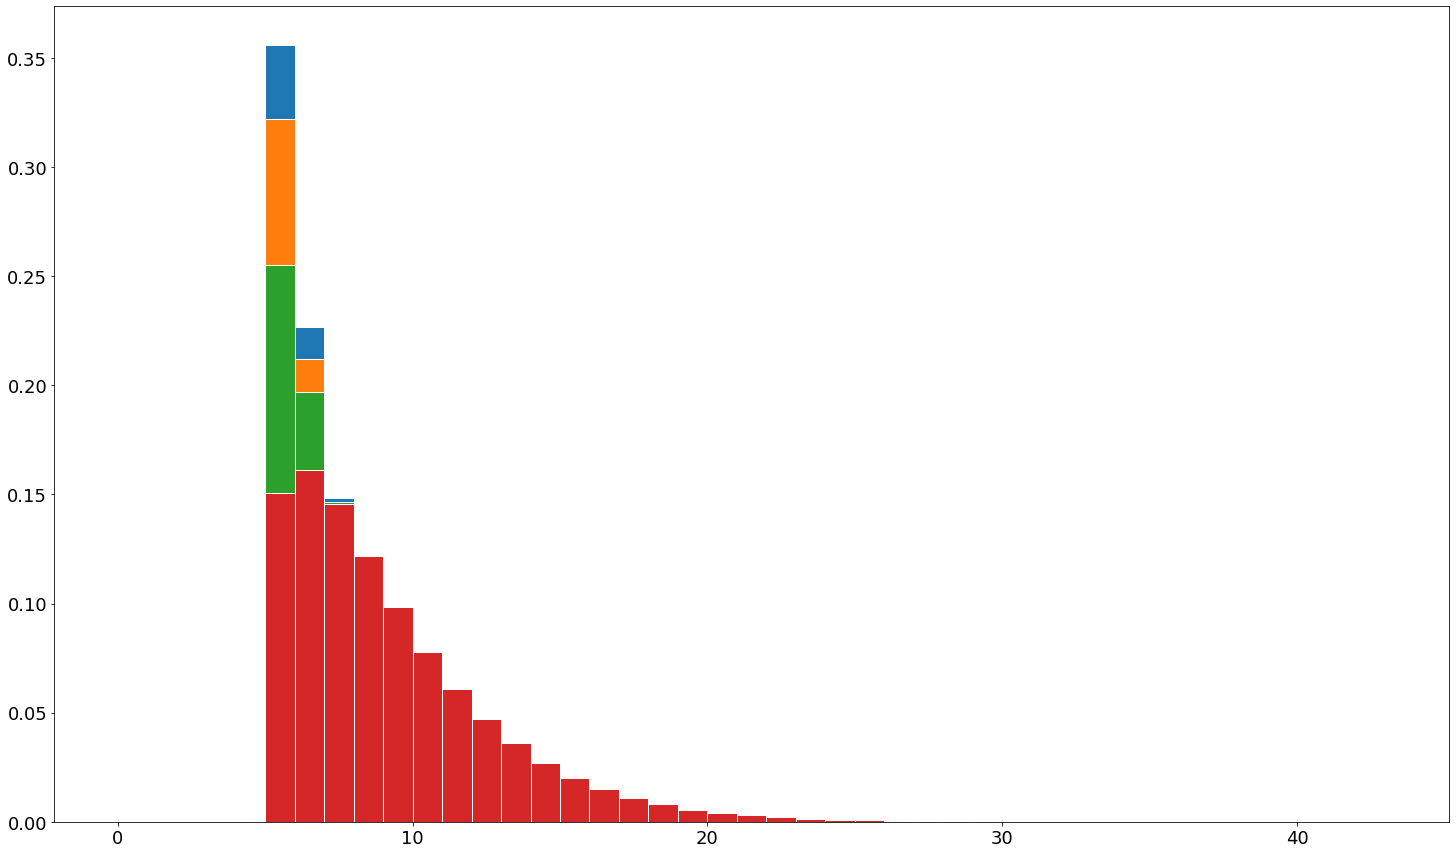

In [7]:
init = time.time()
skip_first_cols, n_inner_slices, n_outer_slices = 3, 12, 20

train_1ar39 = undersample_argon(dfcut1ar39, round(len(train_ar41)*.30), augment_from_pe=20, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_2ar39 = undersample_argon(dfcut2ar39, round(len(train_ar41)*.30), augment_from_pe=25, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_3ar39 = undersample_argon(dfcut3ar39, round(len(train_ar41)*.20), augment_from_pe=30, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_4ar39 = undersample_argon(dfcut4ar39, round(len(train_ar41)*.20), augment_from_pe=35, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
print("[Info] Undersampling in {:.3f} seconds.".format(time.time() - init))

# compact ar39 training data
train_ar39 = pd.concat([train_1ar39, train_2ar39, train_3ar39, train_4ar39], axis=0)
print("[Info] Selected {} instances".format(len(train_ar39)))

# features selection
The process of feature selection has been exposed in the previous notebook. We omit it here.

In [8]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

In [9]:
# Compute features muon
import time

init = time.time()
df_ar41_feat = pd.DataFrame()
df_ar41_feat["PEDetected_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialVar_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialVar_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_tot"] = df_ar41_feat["PEDetected_inner"] + df_ar41_feat["PEDetected_outer"]
df_ar41_feat["NActiveSlices_tot"] = df_ar41_feat["NActiveSlices_inner"] + df_ar41_feat["NActiveSlices_outer"]
df_ar41_feat["MeanNPEActive_tot"] = df_ar41_feat["PEDetected_tot"] / df_ar41_feat["NActiveSlices_tot"]
df_ar41_feat = df_ar41_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

init = time.time()
df_ar39_feat = pd.DataFrame()
df_ar39_feat["PEDetected_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar39_feat["NActiveSlices_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39_feat["MeanNPEActive_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar39_feat["SpatialRange_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar39_feat["SpatialVar_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar39_feat["PEDetected_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar39_feat["NActiveSlices_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39_feat["MeanNPEActive_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar39_feat["SpatialRange_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar39_feat["SpatialVar_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar39_feat["PEDetected_tot"] = df_ar39_feat["PEDetected_inner"] + df_ar39_feat["PEDetected_outer"]
df_ar39_feat["NActiveSlices_tot"] = df_ar39_feat["NActiveSlices_inner"] + df_ar39_feat["NActiveSlices_outer"]
df_ar39_feat["MeanNPEActive_tot"] = df_ar39_feat["PEDetected_tot"] / df_ar39_feat["NActiveSlices_tot"]
df_ar39_feat = df_ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.533 sec
Compute Mu Outer features: 0.741 sec
Compute combined features: 0.003 sec
Compute Ar39 Inner features: 0.660 sec
Compute Ar39 Outer features: 0.700 sec
Compute combined features: 0.003 sec


In [10]:
selected_features = ["PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialRange_inner", "SpatialVar_inner",
                     "PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialRange_outer", "SpatialVar_outer",
                     "PEDetected_tot", "NActiveSlices_tot", "MeanNPEActive_tot"]

# train/val linear models

In [106]:
# ml imports
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
# models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier, Lasso, PassiveAggressiveClassifier, ElasticNet
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix as cv
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier

In [12]:
names = ["Linear SVM",
         "Logistic Regression",
         "Ridge",
         "ElasticNet"]
classifiers = [
    make_pipeline(StandardScaler(), SVC(kernel="linear", C=0.05)),
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, C=.05)),
    make_pipeline(StandardScaler(), RidgeClassifier()), 
    make_pipeline(StandardScaler(), SGDClassifier(penalty="elasticnet"))
]

In [13]:
# data preparation
df_ar39_feat["y"] = 0
df_ar41_feat["y"] = 1
# data preparation
data = pd.concat([df_ar39_feat, df_ar41_feat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = X.loc[:, selected_features]
X = np.array(X)
y = np.array(y)

[Info] KFold - Iteration 0 ....
[Info] KFold - Iteration 1 ....
[Info] KFold - Iteration 2 ....
[Info] KFold - Iteration 3 ....
[Info] KFold - Iteration 4 ....

Linear SVM: 0.86388
Logistic Regression: 0.86775
Ridge: 0.84613
ElasticNet: 0.85599


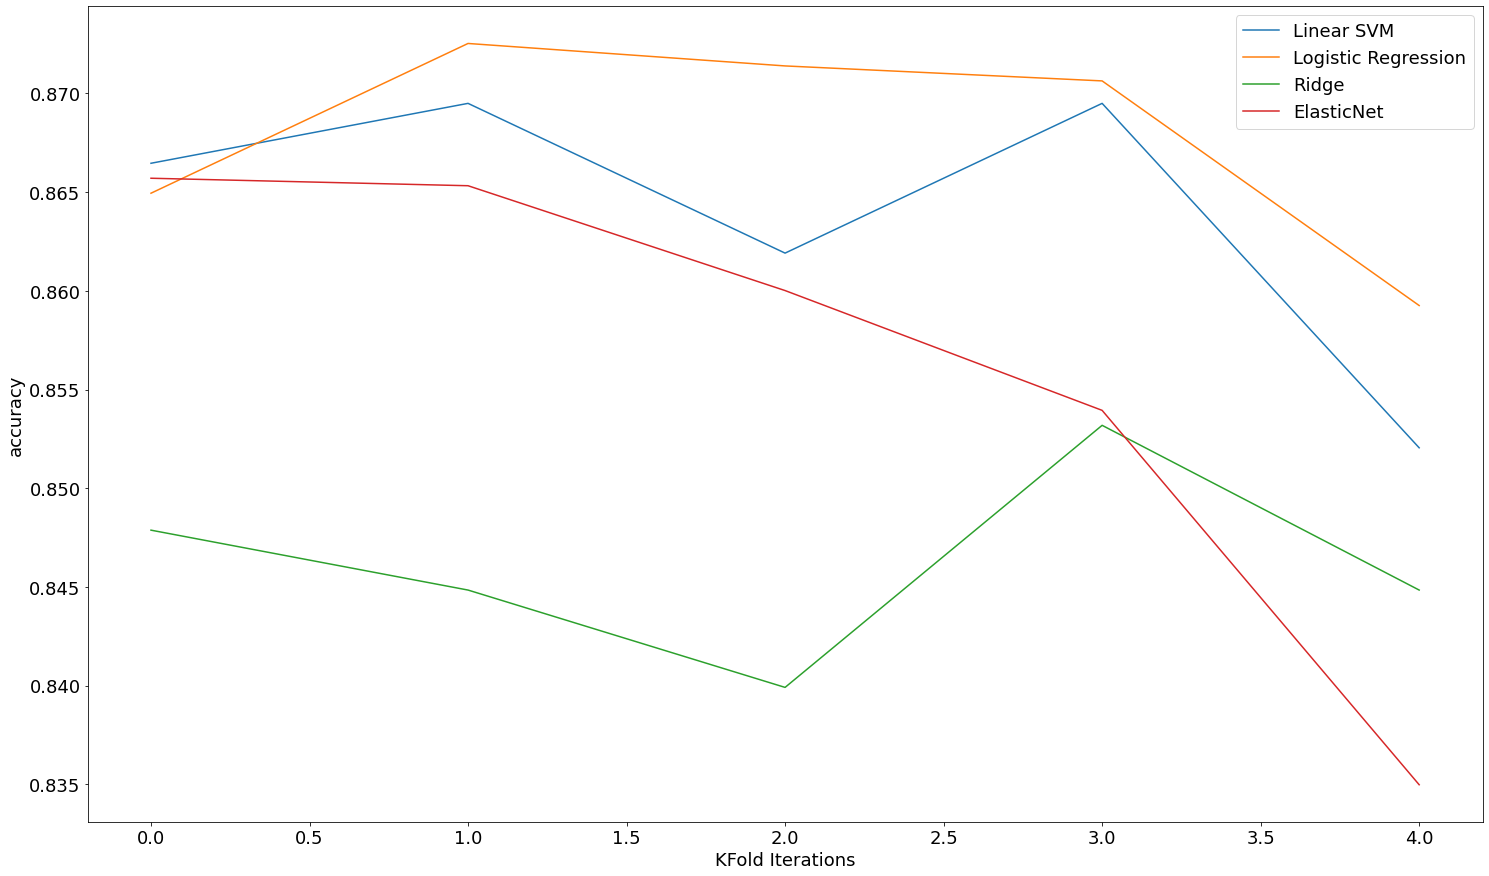

In [14]:
import time
from sklearn.model_selection import KFold

model_template   = "[Info] Model: {}"
result_template  = "[Info] Complete training in {:.3f} seconds.\n"
result_template += "[Result] Score: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}"
confusion_matrix = "[Info] TN: {}, FP: {}, FN: {}, TP: {}"

# Start kfold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
evaluations = [[] for name in names]
for iteration, (train_ids, test_ids) in enumerate(kf.split(X)):
    print("[Info] KFold - Iteration {} ".format(iteration), end='')
    X_train, X_test = X[train_ids], X[test_ids]
    y_train, y_test = y[train_ids], y[test_ids]
    # iterate over classifiers
    for i, (name, clf) in enumerate(zip(names, classifiers)):
        print(".", end="")
        start = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start
        score = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred.round())
        precision = precision_score(y_test, y_pred.round())
        recall = recall_score(y_test, y_pred.round())
        tn, fp, fn, tp = cv(y_test, y_pred.round()).ravel()
        evaluations[i].append({'accuracy': accuracy, 'precision': precision, 'recall': recall})
    print()
print()
metric = "accuracy"
for i, name in enumerate(names):
    line = [eva[metric] for eva in evaluations[i]]
    plt.plot(range(len(line)), line, label=name)
    print("{}: {:.5f}".format(name, sum(line)/len(line)))
plt.xlabel("KFold Iterations")
plt.ylabel(metric)
plt.legend()
plt.show()

# tune linear svm

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components=2)

In [40]:
X2 = pca.fit_transform(X)

In [45]:
scaler = StandardScaler()

In [47]:
X2 = scaler.fit_transform(X2)

No handles with labels found to put in legend.


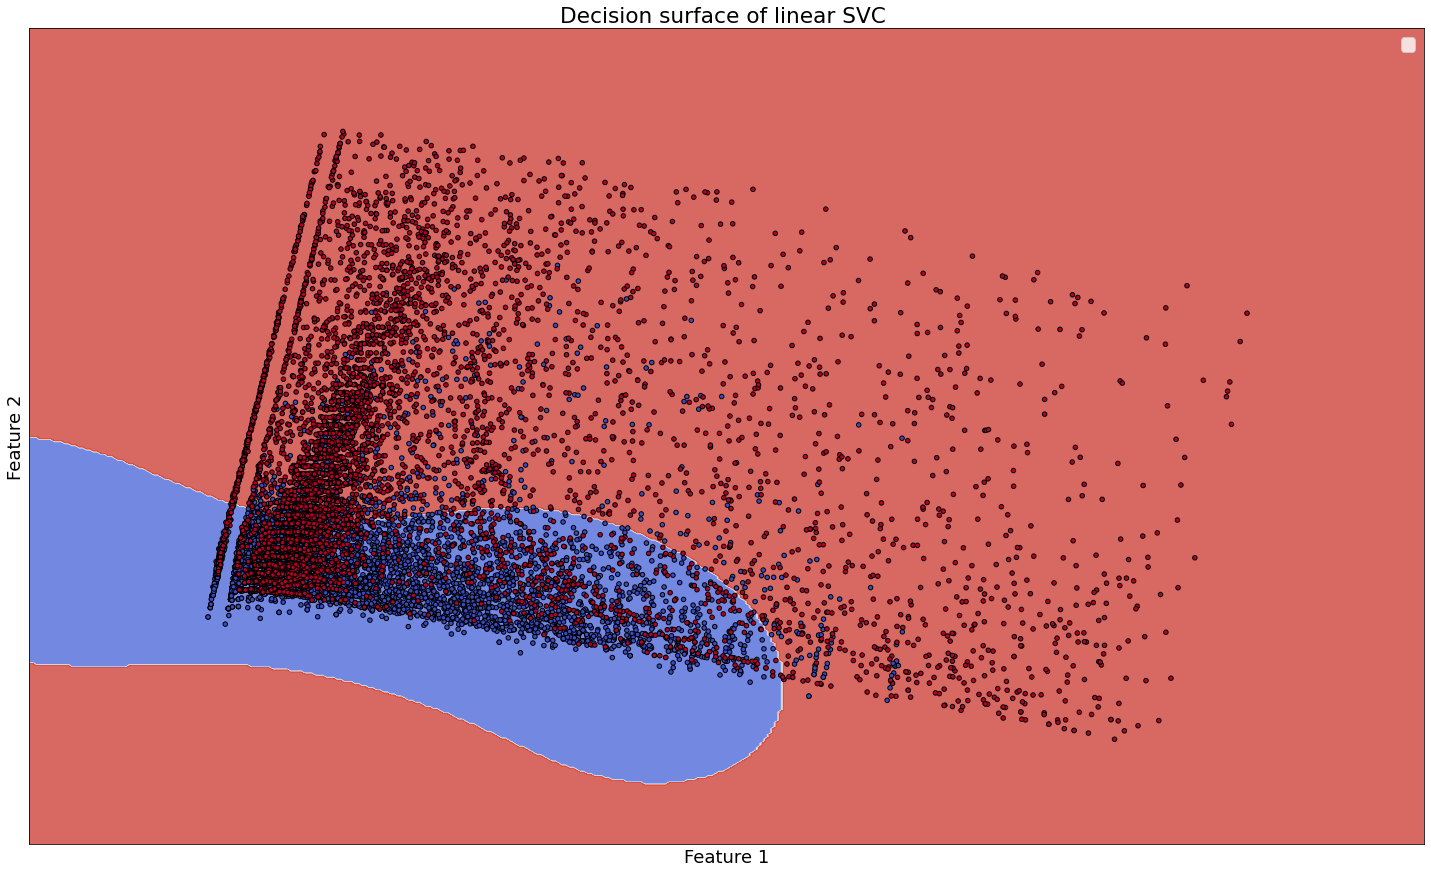

In [69]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = SVC(kernel='rbf', C=.05)
clf = model.fit(X2, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X2[:, 0], X2[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Feature 2')
ax.set_xlabel('Feature 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

# tune svm

In [144]:
# baseline: default logit
svm = SVC(C=.05, probability=True)
results = cross_validate(svm, X, y)
sum(results["test_score"])/len(results["test_score"])

0.8736722306525037

In [145]:
svm.fit(X, y)

SVC(C=0.05, probability=True)

# tune logistic regression

In [89]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler

In [75]:
# baseline: default logit
logit = LogisticRegression(max_iter=500)
results = cross_validate(logit, X, y)
sum(results["test_score"])/len(results["test_score"])

0.8619878603945372

In [92]:
# baseline: default logit
logit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
results = cross_validate(logit, X, y)
sum(results["test_score"])/len(results["test_score"])

0.8619119878603947

In [93]:
logit_param_grid = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-5, 5, 500)
}

logit = LogisticRegression(max_iter=500)

# run grid search
random_grid_logit = RandomizedSearchCV(logit, param_distributions=logit_param_grid, n_iter=500, cv=5, verbose=2, n_jobs=-1)
random_grid_logit.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(random_grid_logit.best_params_)
print(random_grid_logit.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   36.7s finished


[Info] Randomized Search + Cross-Validation
{'penalty': 'l2', 'C': 0.02436540009125466}
0.8623672230652504


In [104]:
logit_param_grid = {
    'C' : np.logspace(-2, 1, 100)
}

logit = LogisticRegression(penalty='l2', max_iter=500)

# run grid search
grid_logit = GridSearchCV(logit, param_grid=logit_param_grid, cv=5, verbose=2, n_jobs=-1)
grid_logit.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(grid_logit.best_params_)
print(grid_logit.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.5s finished


[Info] Randomized Search + Cross-Validation
{'C': 0.023101297000831605}
0.8623672230652504


In [133]:
logit = LogisticRegression(C=.0231, penalty='l2', max_iter=500)
logit.fit(X, y)

LogisticRegression(C=0.0231, max_iter=500)

# tune elastic-net

In [137]:
# baseline: default elasticnet
elast = ElasticNet()

# Start kfold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
evaluations = []
for iteration, (train_ids, test_ids) in enumerate(kf.split(X)):
    X_train, X_test = X[train_ids], X[test_ids]
    y_train, y_test = y[train_ids], y[test_ids]
    
    elast.fit(X_train, y_train)
    y_pred = elast.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred.round())
    evaluations.append(accuracy)
sum(evaluations) / len(evaluations)

0.7712443095599394

In [138]:
elast.fit(X, y)

ElasticNet()

# tune ridge

In [121]:
ridge_param_grid = {
    'alpha' : np.logspace(-5, 5, 1000)
}

ridge = RidgeClassifier()

# run grid search
random_grid_ridge = RandomizedSearchCV(ridge, param_distributions=ridge_param_grid, n_iter=500, cv=5, verbose=2, n_jobs=-1)
random_grid_ridge.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(random_grid_ridge.best_params_)
print(random_grid_ridge.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2470 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    5.6s finished


[Info] Randomized Search + Cross-Validation
{'alpha': 3376.980310825095}
0.844309559939302


In [122]:
ridge_param_grid = {
    'alpha' : np.logspace(3, 10, 1000)
}

ridge = RidgeClassifier()

# run grid search
random_grid_ridge = RandomizedSearchCV(ridge, param_distributions=ridge_param_grid, n_iter=500, cv=5, verbose=2, n_jobs=-1)
random_grid_ridge.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(random_grid_ridge.best_params_)
print(random_grid_ridge.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.5s


[Info] Randomized Search + Cross-Validation
{'alpha': 3463.6941773717344}
0.8440060698027313


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    5.7s finished


In [124]:
ridge = RidgeClassifier(alpha=3464)
results = cross_validate(ridge, X, y)
sum(results["test_score"])/len(results["test_score"])

0.8440060698027313

In [139]:
ridge.fit(X, y)

RidgeClassifier(alpha=3464)

# test linear models

In [125]:
# Compute features muon
import time

init = time.time()
df_test_ar41_feat = pd.DataFrame()
df_test_ar41_feat["PEDetected_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_ar41_feat["NActiveSlices_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_ar41_feat["MeanNPEActive_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_ar41_feat["SpatialRange_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_ar41_feat["SpatialVar_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar41 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_ar41_feat["PEDetected_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_ar41_feat["NActiveSlices_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_ar41_feat["MeanNPEActive_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_ar41_feat["SpatialRange_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_ar41_feat["SpatialVar_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar41 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_ar41_feat["PEDetected_tot"] = df_test_ar41_feat["PEDetected_inner"] + df_test_ar41_feat["PEDetected_outer"]
df_test_ar41_feat["NActiveSlices_tot"] = df_test_ar41_feat["NActiveSlices_inner"] + df_test_ar41_feat["NActiveSlices_outer"]
df_test_ar41_feat["MeanNPEActive_tot"] = df_test_ar41_feat["PEDetected_tot"] / df_test_ar41_feat["NActiveSlices_tot"]
df_test_ar41_feat = df_test_ar41_feat.fillna(-1)
df_test_ar41_feat = df_test_ar41_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar41 Inner features: 0.068 sec
Compute Ar41 Outer features: 0.084 sec
Compute combined features: 0.004 sec


In [126]:
import time

init = time.time()
df_test_1ar39_feat = pd.DataFrame()
df_test_1ar39_feat["PEDetected_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_1ar39_feat["NActiveSlices_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_1ar39_feat["MeanNPEActive_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_1ar39_feat["SpatialRange_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_1ar39_feat["SpatialVar_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_1ar39_feat["PEDetected_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_1ar39_feat["NActiveSlices_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_1ar39_feat["MeanNPEActive_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_1ar39_feat["SpatialRange_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_1ar39_feat["SpatialVar_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_1ar39_feat["PEDetected_tot"] = df_test_1ar39_feat["PEDetected_inner"] + df_test_1ar39_feat["PEDetected_outer"]
df_test_1ar39_feat["NActiveSlices_tot"] = df_test_1ar39_feat["NActiveSlices_inner"] + df_test_1ar39_feat["NActiveSlices_outer"]
df_test_1ar39_feat["MeanNPEActive_tot"] = df_test_1ar39_feat["PEDetected_tot"] / df_test_1ar39_feat["NActiveSlices_tot"]
df_test_1ar39_feat = df_test_1ar39_feat.fillna(-1)
df_test_1ar39_feat = df_test_1ar39_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 46.979 sec
Compute Ar39 Outer features: 50.365 sec
Compute combined features: 0.039 sec


In [127]:
import time

init = time.time()
df_test_2ar39_feat = pd.DataFrame()
df_test_2ar39_feat["PEDetected_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_2ar39_feat["NActiveSlices_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_2ar39_feat["MeanNPEActive_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_2ar39_feat["SpatialRange_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_2ar39_feat["SpatialVar_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_2ar39_feat["PEDetected_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_2ar39_feat["NActiveSlices_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_2ar39_feat["MeanNPEActive_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_2ar39_feat["SpatialRange_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_2ar39_feat["SpatialVar_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_2ar39_feat["PEDetected_tot"] = df_test_2ar39_feat["PEDetected_inner"] + df_test_2ar39_feat["PEDetected_outer"]
df_test_2ar39_feat["NActiveSlices_tot"] = df_test_2ar39_feat["NActiveSlices_inner"] + df_test_2ar39_feat["NActiveSlices_outer"]
df_test_2ar39_feat["MeanNPEActive_tot"] = df_test_2ar39_feat["PEDetected_tot"] / df_test_2ar39_feat["NActiveSlices_tot"]
df_test_2ar39_feat = df_test_2ar39_feat.fillna(-1)
df_test_2ar39_feat = df_test_2ar39_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 80.105 sec
Compute Ar39 Outer features: 90.956 sec
Compute combined features: 0.071 sec


In [128]:
import time

init = time.time()
df_test_3ar39_feat = pd.DataFrame()
df_test_3ar39_feat["PEDetected_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_3ar39_feat["NActiveSlices_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_3ar39_feat["MeanNPEActive_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_3ar39_feat["SpatialRange_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_3ar39_feat["SpatialVar_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_3ar39_feat["PEDetected_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_3ar39_feat["NActiveSlices_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_3ar39_feat["MeanNPEActive_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_3ar39_feat["SpatialRange_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_3ar39_feat["SpatialVar_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_3ar39_feat["PEDetected_tot"] = df_test_3ar39_feat["PEDetected_inner"] + df_test_3ar39_feat["PEDetected_outer"]
df_test_3ar39_feat["NActiveSlices_tot"] = df_test_3ar39_feat["NActiveSlices_inner"] + df_test_3ar39_feat["NActiveSlices_outer"]
df_test_3ar39_feat["MeanNPEActive_tot"] = df_test_3ar39_feat["PEDetected_tot"] / df_test_3ar39_feat["NActiveSlices_tot"]
df_test_3ar39_feat = df_test_3ar39_feat.fillna(-1)
df_test_3ar39_feat = df_test_3ar39_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 106.888 sec
Compute Ar39 Outer features: 125.633 sec
Compute combined features: 0.115 sec


In [129]:
import time

init = time.time()
df_test_4ar39_feat = pd.DataFrame()
df_test_4ar39_feat["PEDetected_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_4ar39_feat["NActiveSlices_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_4ar39_feat["MeanNPEActive_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_4ar39_feat["SpatialRange_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_4ar39_feat["SpatialVar_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_4ar39_feat["PEDetected_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_4ar39_feat["NActiveSlices_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_4ar39_feat["MeanNPEActive_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_4ar39_feat["SpatialRange_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_4ar39_feat["SpatialVar_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_4ar39_feat["PEDetected_tot"] = df_test_4ar39_feat["PEDetected_inner"] + df_test_4ar39_feat["PEDetected_outer"]
df_test_4ar39_feat["NActiveSlices_tot"] = df_test_4ar39_feat["NActiveSlices_inner"] + df_test_4ar39_feat["NActiveSlices_outer"]
df_test_4ar39_feat["MeanNPEActive_tot"] = df_test_4ar39_feat["PEDetected_tot"] / df_test_4ar39_feat["NActiveSlices_tot"]
df_test_4ar39_feat = df_test_4ar39_feat.fillna(-1)
df_test_4ar39_feat = df_test_4ar39_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 111.412 sec
Compute Ar39 Outer features: 132.660 sec
Compute combined features: 0.114 sec


In [130]:
# create label
df_test_1ar39_feat["y"] = -1    # since label not used, we use it to mark the class of pileup
df_test_2ar39_feat["y"] = -2
df_test_3ar39_feat["y"] = -3
df_test_4ar39_feat["y"] = -4
df_test_ar41_feat["y"] = 1

# data preparation
all_test_data = pd.concat([df_test_1ar39_feat, df_test_2ar39_feat, 
                           df_test_3ar39_feat, df_test_4ar39_feat, df_test_ar41_feat], axis=0)
XX, yy = all_test_data.iloc[:, :-1], all_test_data.iloc[:, -1]
XX = XX.loc[:, selected_features]
XX = np.array(XX)
yy = np.where(yy<0, 0, 1)

In [146]:
# inference
init = time.time()
y_pred_proba_logit = logit.predict_proba(XX)
print("[Info] Inference {} instances wt Logistic Regression: {:.3f} seconds".format(XX.shape[0], time.time()-init))

init = time.time()
y_pred_proba_ridge = ridge.predict(XX)
print("[Info] Inference {} instances wt Ridge: {:.3f} seconds".format(XX.shape[0], time.time()-init))

init = time.time()
y_pred_proba_elastic = elast.predict(XX)
print("[Info] Inference {} instances wt Elastic Net: {:.3f} seconds".format(XX.shape[0], time.time()-init))

init = time.time()
y_pred_proba_svm = svm.predict_proba(XX)
print("[Info] Inference {} instances wt SVM: {:.3f} seconds".format(XX.shape[0], time.time()-init))

[Info] Inference 3643726 instances wt Logistic Regression: 0.117 seconds
[Info] Inference 3643726 instances wt Ridge: 0.051 seconds
[Info] Inference 3643726 instances wt Elastic Net: 0.038 seconds
[Info] Inference 3643726 instances wt SVM: 528.646 seconds


IndexError: too many indices for array

In [153]:
all_test_data["y_logit"] = y_pred_proba_logit[:, 1]
all_test_data["y_elastic"] = y_pred_proba_elastic
all_test_data["y_svm"] = y_pred_proba_svm[:, 1]

In [159]:
logit_prec = precision_score(yy, np.where(all_test_data["y_logit"].to_numpy()<=0.5, 0, 1))
elastic_prec = precision_score(yy, np.where(all_test_data["y_elastic"].to_numpy()<=0.5, 0, 1))
svm_prec = precision_score(yy, np.where(all_test_data["y_svm"].to_numpy()<=0.5, 0, 1))
print("[Info] Precision Logistic Regression: {:.5f}".format(logit_prec))
print("[Info] Precision ElasticNet: {:.5f}".format(elastic_prec))
print("[Info] Precision SVM: {:.5f}".format(svm_prec))

[Info] Precision Logistic Regression: 0.00102
[Info] Precision ElasticNet: 0.00216
[Info] Precision SVM: 0.00085


In [156]:
# plot roc curve
logit_fpr, logit_tpr, logit_threshold = roc_curve(yy, all_test_data["y_logit"])
elastic_fpr, elastic_tpr, elastic_threshold = roc_curve(yy, all_test_data["y_elastic"])
svm_fpr, svm_tpr, svm_threshold = roc_curve(yy, all_test_data["y_svm"])

[Info] LogisticRegression: Threshold: 0.50 => TPR: 0.857, FPR=0.165
[Info] ElasticNet: Threshold: 0.50 => TPR: 0.589, FPR=0.054
[Info] SVM: Threshold: 0.50 => TPR: 0.864, FPR=0.204


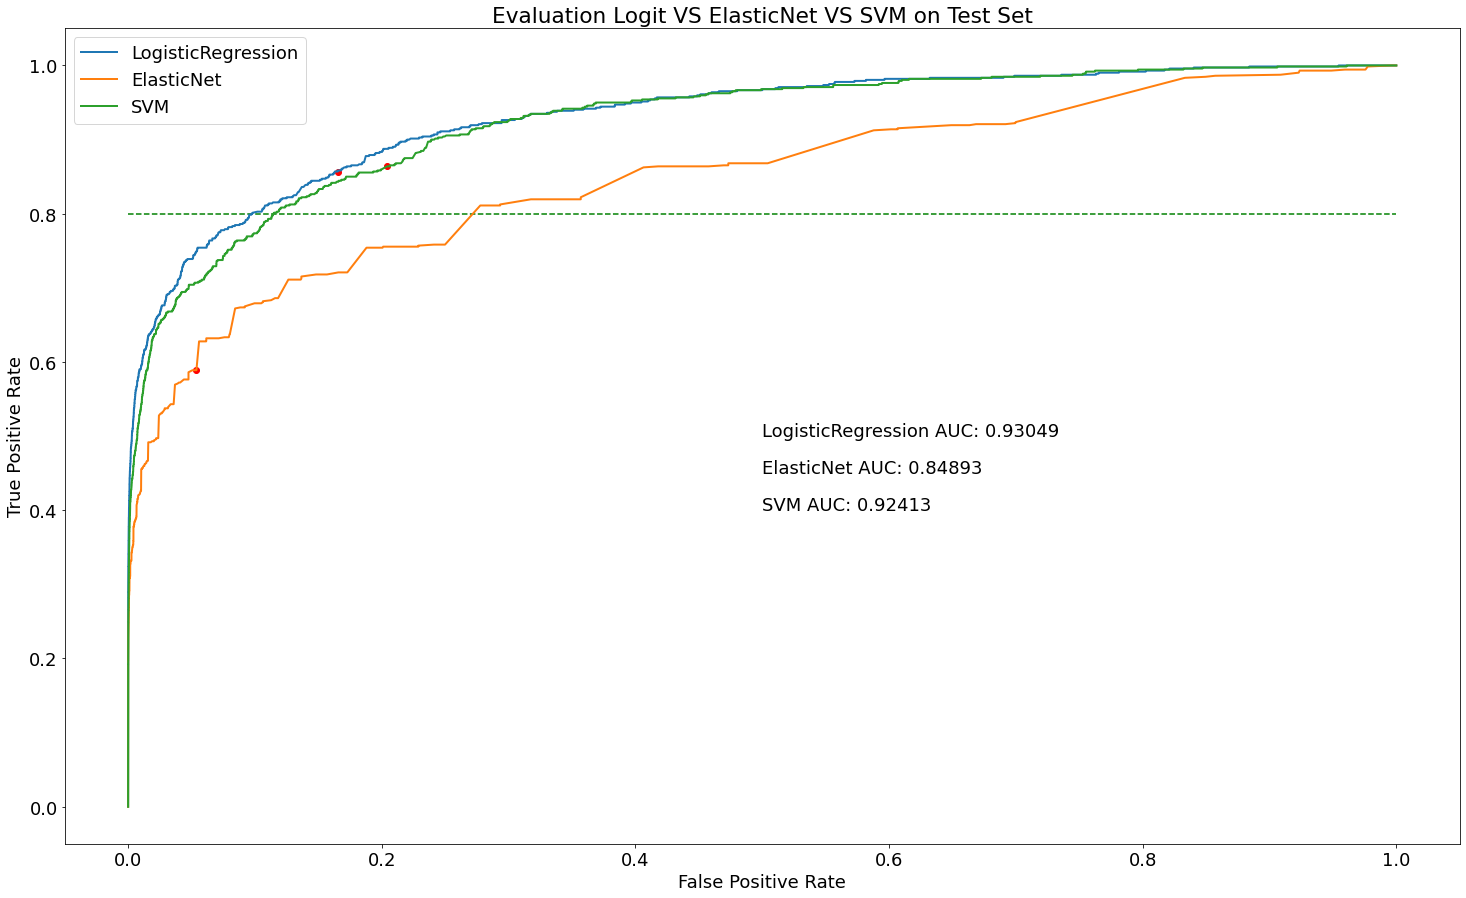

In [157]:
plt.plot(logit_fpr, logit_tpr, label="LogisticRegression", linewidth=2)
logit_mid_threshold = np.argmin(abs(logit_threshold-.50))
plt.scatter(logit_fpr[logit_mid_threshold], logit_tpr[logit_mid_threshold], color='r')
plt.text(.5, .5, "LogisticRegression AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_logit"])))
print("[Info] LogisticRegression: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(logit_threshold[logit_mid_threshold], 
                                                                                       logit_tpr[logit_mid_threshold], 
                                                                                       logit_fpr[logit_mid_threshold]))

plt.plot(elastic_fpr, elastic_tpr, label="ElasticNet", linewidth=2)
elastic_mid_threshold = np.argmin(abs(elastic_threshold-.50))
plt.scatter(elastic_fpr[elastic_mid_threshold], elastic_tpr[elastic_mid_threshold], color='r')
plt.text(.5, .45, "ElasticNet AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_elastic"])))
print("[Info] ElasticNet: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(elastic_threshold[elastic_mid_threshold], 
                                                                               elastic_tpr[elastic_mid_threshold], 
                                                                               elastic_fpr[elastic_mid_threshold]))

plt.plot(svm_fpr, svm_tpr, label="SVM", linewidth=2)
svm_mid_threshold = np.argmin(abs(svm_threshold-.50))
plt.scatter(svm_fpr[svm_mid_threshold], svm_tpr[svm_mid_threshold], color='r')
plt.text(.5, .40, "SVM AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_svm"])))
print("[Info] SVM: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(svm_threshold[svm_mid_threshold], 
                                                                        svm_tpr[svm_mid_threshold], 
                                                                        svm_fpr[svm_mid_threshold]))

plt.hlines(.80, 0, 1, color='g', linestyle='dashed')
plt.title("Evaluation Logit VS ElasticNet VS SVM on Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [160]:
# best model: Random forest
# assuming we aim .80 tpr
id_tpr80 = np.argmin(abs(logit_tpr-.80))
print("[Info] LogisticRegression: Threshold: {:.3f} => TPR: {:.3f}, FPR: {:.3f}".format(logit_threshold[id_tpr80], 
                                                                                  logit_tpr[id_tpr80], 
                                                                                  logit_fpr[id_tpr80]))

[Info] LogisticRegression: Threshold: 0.589 => TPR: 0.800, FPR: 0.097


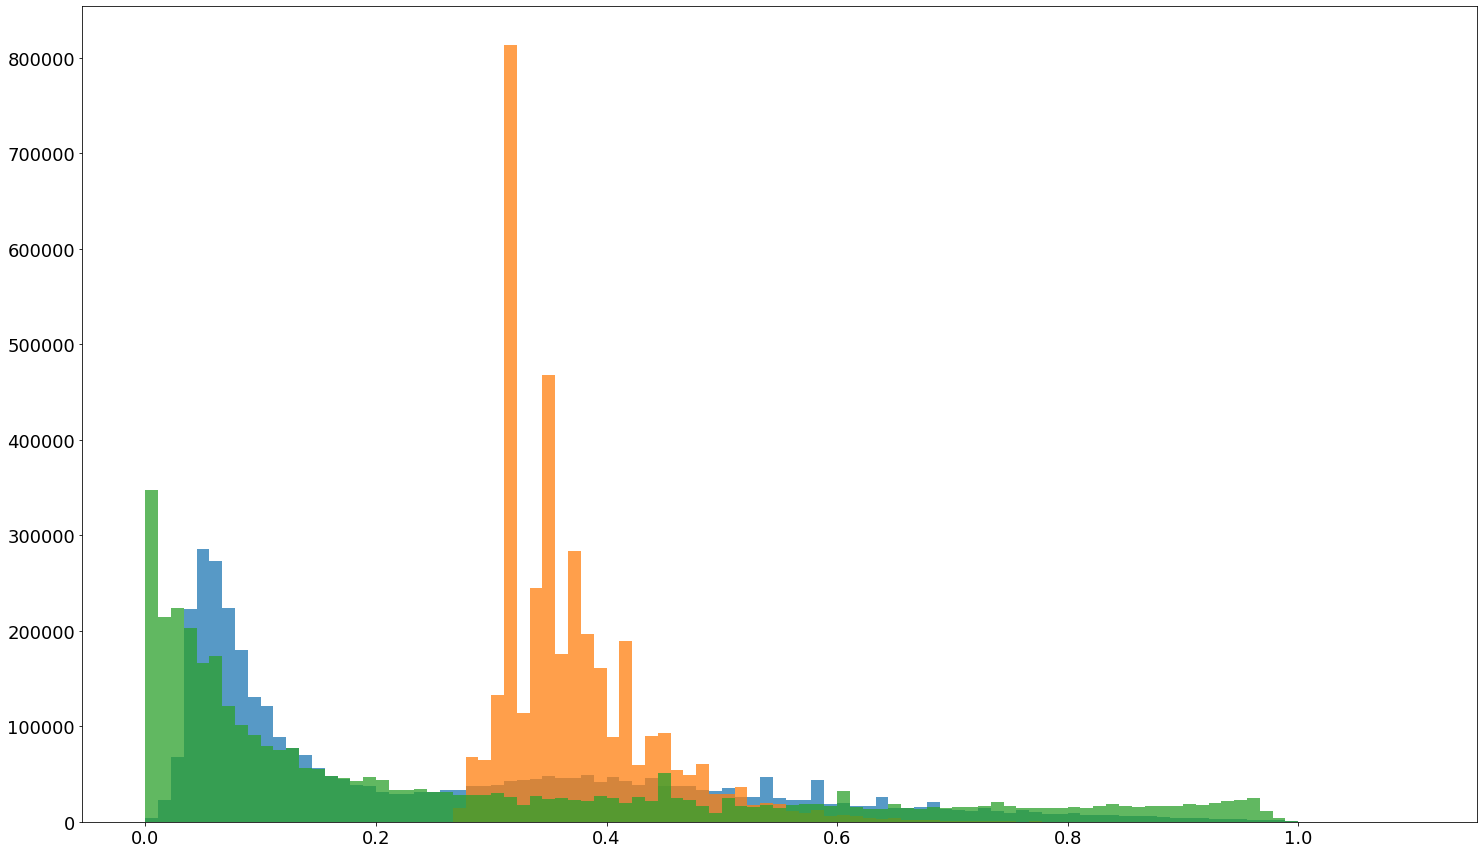

In [161]:
bins=np.linspace(0, 1.1, 100)
plt.hist(all_test_data["y_logit"], bins=bins, alpha=.75)
plt.hist(all_test_data["y_elastic"], bins=bins, alpha=.75)
plt.hist(all_test_data["y_svm"], bins=bins, alpha=.75)
plt.show()

# see single ar39 subclasses

In [162]:
fprates = []
for ar39 in [-1, -2, -3, -4]:
    logit_fpr_ar39 = len(all_test_data[(all_test_data.y==ar39) & (all_test_data.y_logit>.5)]) / len(all_test_data[all_test_data.y==ar39])
    elastic_fpr_ar39 = len(all_test_data[(all_test_data.y==ar39) & (all_test_data.y_elastic>.5)]) / len(all_test_data[all_test_data.y==ar39])
    svm_fpr_ar39 = len(all_test_data[(all_test_data.y==ar39) & (all_test_data.y_svm>.5)]) / len(all_test_data[all_test_data.y==ar39])
    fprates.append([logit_fpr_ar39, elastic_fpr_ar39, svm_fpr_ar39])

In [163]:
fprates

[[0.15688829908144467, 0.011571242701674096, 0.17409470450574882],
 [0.13997579620743156, 0.02423624055252908, 0.17346932643993937],
 [0.15488382664032588, 0.04719225860591968, 0.1911956502736062],
 [0.195469060683616, 0.09627934845029561, 0.23584569013878792]]

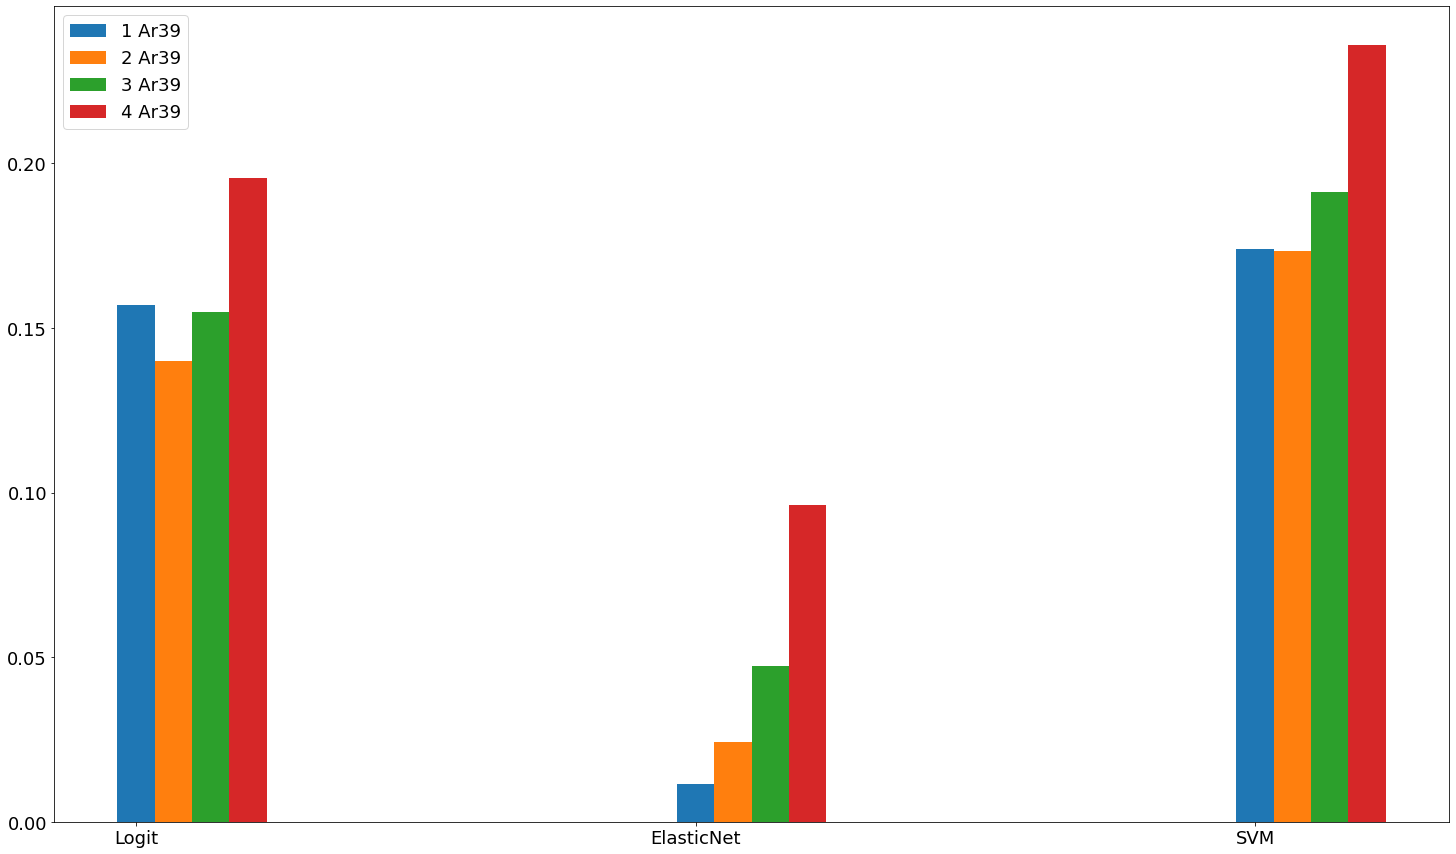

In [164]:
plt.bar(np.linspace(0, 3, 3) +.0, fprates[0], width=.1, label="1 Ar39")
plt.bar(np.linspace(0, 3, 3) +.1, fprates[1], width=.1, label="2 Ar39")
plt.bar(np.linspace(0, 3, 3) +.2, fprates[2], width=.1, label="3 Ar39")
plt.bar(np.linspace(0, 3, 3) +.3, fprates[3], width=.1, label="4 Ar39")
plt.xticks(np.linspace(0, 3, 3), ["Logit", "ElasticNet", "SVM"])
plt.legend()
plt.show()

# save models

In [165]:
from joblib import dump

In [166]:
dump(logit, 'models/logit_08_09_2020.joblib') 
dump(elast, 'models/elastic_08_09_2020.joblib') 
dump(svm, 'models/svm_08_09_2020.joblib') 
print("[Info] Saved models.")

[Info] Saved models.
